# 第一步 导入必要的库，并定义DQN网络架构
# Первым шагом является импорт необходимых библиотек и определение архитектуры сети DQN
     


In [25]:
# 安装必要的库
!pip install gym[atari] gym[accept-rom-license] torch torchvision numpy matplotlib opencv-python

# 导入必要的库
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import cv2


# 第二步 定义Replay Memory
# Определение памяти для воспроизведения


In [26]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



# 第三步 定义DQN模型，使用卷积神经网络
# Третьим шагом является определение модели DQN и использование сверточных нейронных сетей



In [27]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self._feature_size(h, w), 512)
        self.fc2 = nn.Linear(512, outputs)

    def _feature_size(self, h, w):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, 4, h, w)))).view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        return self.fc2(x)



# 第四步 定义图像预处理函数，将图像转换为灰度图并调整大小
# Четвертый шаг заключается в определении функции предварительной обработки изображения, преобразовании изображения в оттенки серого и настройке размера


In [28]:
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (84, 84), interpolation=cv2.INTER_AREA)
    image = np.expand_dims(image, axis=0)  # 增加一个维度，以匹配卷积层的输入
    image = torch.tensor(image, dtype=torch.float32)
    return image



# 第五步 运行DQN代理
# Шаг 5 Запустите агент DQN



In [29]:
class DQNAgent:
    def __init__(self, env, BATCH_SIZE=128, GAMMA=0.999, EPS_START=0.9, EPS_END=0.05, EPS_DECAY=200, TAU=0.005, LR=1e-4):
        self.env = env
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.TAU = TAU
        self.LR = LR

        self.n_actions = env.action_space.n
        self.policy_net = DQN(84, 84, self.n_actions).to(device)
        self.target_net = DQN(84, 84, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.LR)
        self.memory = ReplayMemory(10000)
        self.steps_done = 0
        self.episode_durations = []
        self.episode_rewards = []

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def learn(self, num_episodes):
      for i_episode in range(num_episodes):
        state = preprocess(self.env.reset()).to(device)
        state = torch.cat([state] * 4).unsqueeze(0)  # Stack 4 frames
        total_reward = 0
        for t in count():
            action = self.select_action(state)
            next_state, reward, done, info = self.env.step(action.item())
            next_state = preprocess(next_state).to(device)
            reward = torch.tensor([reward], device=device)
            total_reward += reward.item()
            if not done:
                next_state = torch.cat((state[:, 1:, :, :], next_state.unsqueeze(0)), dim=1)
            else:
                next_state = None

            self.memory.push(state, action, next_state, reward)
            state = next_state
            self.optimize_model()
            target_net_state_dict = self.target_net.state_dict()
            policy_net_state_dict = self.policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
            self.target_net.load_state_dict(target_net_state_dict)

            if done:
                self.episode_durations.append(t + 1)
                self.episode_rewards.append(total_reward)
                if i_episode % 10 == 0:
                    print(f"Episode {i_episode}/{num_episodes}, Total Reward: {total_reward}")
                break



# 第六步 运行DQN代理并训练
# Шаг 6 Запустите DQN agent и обучите

In [30]:
env = gym.make('Breakout-v4', new_step_api=True).unwrapped
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = DQNAgent(env)

num_episodes = 50
agent.learn(num_episodes)

env.close()



Episode 0/50, Total Reward: 1.0
Episode 10/50, Total Reward: 0.0
Episode 20/50, Total Reward: 0.0
Episode 30/50, Total Reward: 2.0
Episode 40/50, Total Reward: 1.0


# 第七步 可视化训练结果
# Шаг 7 Визуализируйте результаты обучения


<ipython-input-31-a6c8d2d2867d>:14: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  plt.tight_layout()
<ipython-input-31-a6c8d2d2867d>:14: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from current font.
  plt.tight_layout()
<ipython-input-31-a6c8d2d2867d>:14: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
<ipython-input-31-a6c8d2d2867d>:14: UserWarning: Glyph 25345 (\N{CJK UNIFIED IDEOGRAPH-6301}) missing from current font.
  plt.tight_layout()
<ipython-input-31-a6c8d2d2867d>:14: UserWarning: Glyph 32493 (\N{CJK UNIFIED IDEOGRAPH-7EED}) missing from current font.
  plt.tight_layout()
<ipython-input-31-a6c8d2d2867d>:14: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
<ipython-input-31-a6c8d2d2867d>:14: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
<ipyth

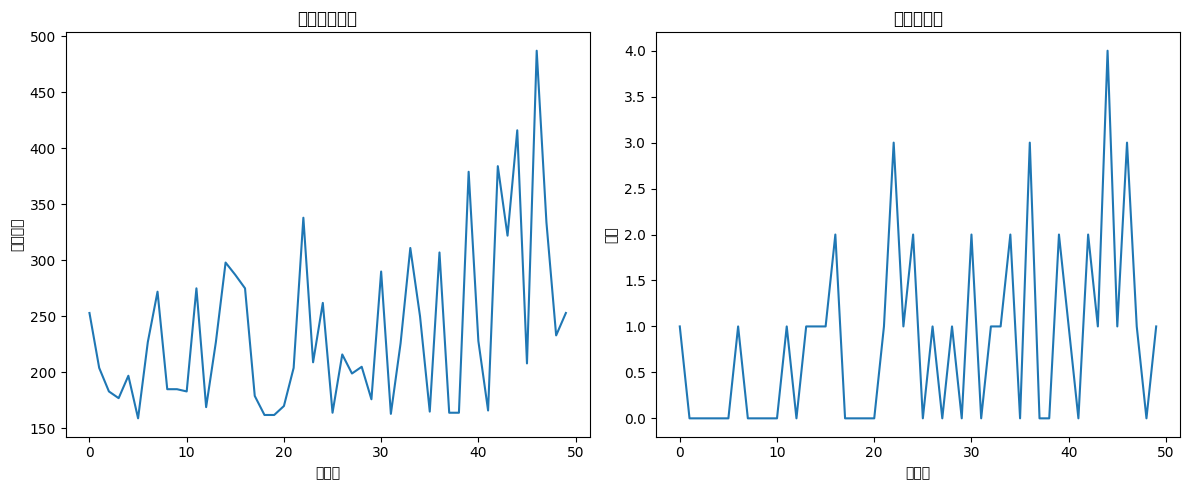

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agent.episode_durations)
plt.title('回合持续时间')
plt.xlabel('回合数')
plt.ylabel('持续时间')

plt.subplot(122)
plt.plot(agent.episode_rewards)
plt.title('每回合奖励')
plt.xlabel('回合数')
plt.ylabel('奖励')

plt.tight_layout()
plt.show()



